In [2]:
#add necessary libraries
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np

import os

# Import required libraries
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.utils.data
import torchvision

from mpl_toolkits import mplot3d

from sklearn.decomposition import PCA



%matplotlib inline

np.random.seed(5)

# https://towardsdatascience.com/build-the-right-autoencoder-tune-and-optimize-using-pca-principles-part-i-1f01f821999b
# https://debuggercafe.com/implementing-deep-autoencoder-in-pytorch/

## Problem 1 AutoEncoder:

Here you are going to construct an Auto-Encoder to reconstruct data generate from a 2-dim function. Below is a short function that creates either cubic or linear data (with noise added). Note that in order to simplify the problem, the (x,y) data are normalized to the [0,1] interval. In this task you will construct train three different models to reconstruct each of the two data sets. For a better idea of what I'm looking for here, see this weeks lecture video on AEs. You are basically carrying out the example I showed there.

#### Model 1:
This is the easy one. You will construct a 1-dimension PCA (one latent dimension that is) and fit it to each data set as a reference. Just use the sklearn implementation. You should find that it does a good job of fitting the linear data but not the non-linear data. 

#### Model 2:
Here you are going to construct the simplest possible AE. You are constructing an AE with a single hidden layer containing a single ReLU unit (representing a 1-dim latent space). This AE will take (x,y) as input, followed by a single neuron layer (1-dim latent space) with a ReLU unit, followed by a 2 neuron layer with sigmoid activation. That's it. So it should look something like this

(x,y) --> Linear(2,1) --> ReLU(1) --> Linear(1,2) --> Sigmoid(2) = (xrecon,yrecon)

In [18]:
class simpleAE(nn.Module):
    def __init__(self):
        super(simpleAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2,1),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(1, 2),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### Model 3:
Here we're going to look at an AE with a 2 layer encoder, 2 layer decoder, again with a single neuron representation layer coding a 1-dim latent representation. We're also going to add some batch normalization (BN) for good measure. Note that the appropriate BN layer in pytorch is BatchNorm1D. This should look something like this.

Define a composite layer as the following

CL(n,m) = Lin(n,m) --> BN(m) --> ReLU(m)

Then the model will be 

(x,y) --> CL(2,100) --> CL(100,50) --> CL(50,1) --> CL(1,50) --> CL(50,100) --> Lin(100,2) --> Sigmoid(20) = (xrecon,yrecon)

In [65]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2,100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100,50),
            nn.BatchNorm1d(50),
            nn.ReLU(True),
            nn.Linear(50,1),
            nn.BatchNorm1d(1),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(1, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(True),
            nn.Linear(50, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 2),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# class AE(nn.Module):
#     def __init__(self, **kwargs):
#         super().__init__()
#         self.encoder_hidden_layer = nn.Linear(
#             in_features=kwargs["input_shape"], out_features=128
#         )
#         self.encoder_output_layer = nn.Linear(
#             in_features=128, out_features=128
#         )
#         self.decoder_hidden_layer = nn.Linear(
#             in_features=128, out_features=128
#         )
#         self.decoder_output_layer = nn.Linear(
#             in_features=128, out_features=kwargs["input_shape"]
#         )

#     def forward(self, features):
#         activation = self.encoder_hidden_layer(features)
#         activation = torch.relu(activation)
#         code = self.encoder_output_layer(activation)
#         code = torch.relu(code)
#         activation = self.decoder_hidden_layer(code)
#         activation = torch.relu(activation)
#         activation = self.decoder_output_layer(activation)
#         reconstructed = torch.relu(activation)
#         return reconstructed

### Data
In the following code, I have code to construct and normalize both linear and nonlinear noisy data. You should use this to create a training set of 1000 points and test set of 1000 points for each type. At the moment, I only construct a single data set, so you will need to do some copy and paste work.

In [7]:
def scale_data(data):
    for i in range(data.shape[1]):
        data[:, i] = (data[:, i] - data[:, i].min()) / (data[:, i].max() - data[:, i].min())
    return data

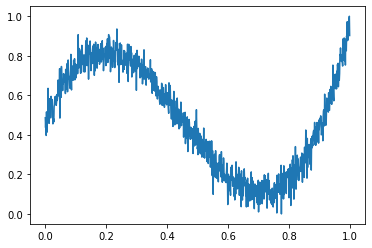

In [8]:
# Cubic
samples = 1000

# Training
np.random.seed(12)
cubic_train = np.empty((samples,2))
cubic_train[:,0] = np.linspace(0,2.2,samples)
cubic_train[:,1] = cubic_train[:,0]**3 - 3*cubic_train[:,0]**2 + 2*cubic_train[:,0]+ 0.05*np.random.randn(cubic_train[:,0].size)
cubic_train = scale_data(cubic_train)

# Test
np.random.seed(13)
cubic_test = np.empty((samples,2))
cubic_test[:,0] = np.linspace(0,2.2,samples)
cubic_test[:,1] = cubic_test[:,0]**3 - 3*cubic_test[:,0]**2 + 2*cubic_test[:,0]+ 0.05*np.random.randn(cubic_test[:,0].size)
cubic_test = scale_data(cubic_test)
    
# Plot to confirm
plt.plot(cubic_train[:,0],cubic_train[:,1])

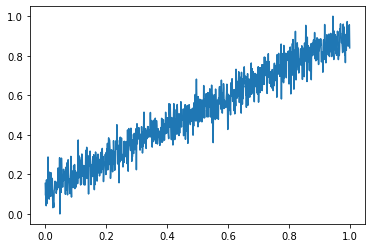

In [9]:
# Linear


samples = 1000
# Train
np.random.seed(12)
linear_train = np.empty((samples,2))
linear_train[:,0] = np.linspace(0,2.2,samples)
linear_train[:,1] = 2*linear_train[:,0] + 20 + 0.3*np.random.randn(linear_train[:,0].size)
linear_train = scale_data(linear_train)


# Train
np.random.seed(12)
linear_test = np.empty((samples,2))
linear_test[:,0] = np.linspace(0,2.2,samples)
linear_test[:,1] = 2*linear_test[:,0] + 20 + 0.3*np.random.randn(linear_test[:,0].size)
linear_test = scale_data(linear_test)

    
# Plot to confirm
plt.plot(linear_train[:,0],linear_train[:,1])

### Task 1:
Fit all three models to the linear data. Use the ADAM optimizer with a lr = 0.0001 (try to vary it and see though). Also, use L2 regularization (the default in torch) with a weight decay of 1e-5. Use the MSE loss function. After you fit each of the three models to the training data, calculate the MSE on the test data as a measure of quality of reconstruction. That is, the MSE between the true input (x,y) data pairs and the reconstructed (x,y). Also, on an overlayed plot, plot the (x,y) test data and the (xrecon,yrecon) reconstructed data to see if it fits.

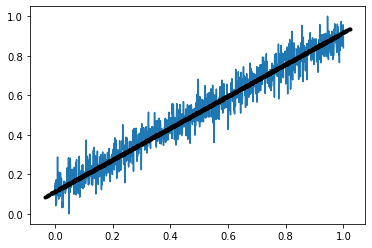

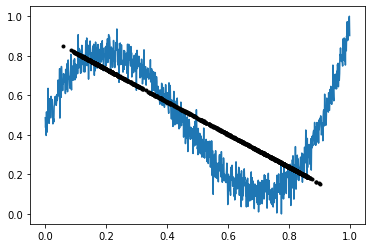

In [17]:
# PCA
# Linear
pca = PCA(n_components = 1)
linear_pca = pca.fit_transform(linear_train)
linear_fit = pca.inverse_transform(linear_pca)

plt.plot(linear_train[:,0],linear_train[:,1])
plt.plot(linear_fit[:,0],linear_fit[:,1],'k.')
plt.show()

# Cubic
cubic_pca = pca.fit_transform(cubic_train)
cubic_fit = pca.inverse_transform(cubic_pca)

plt.plot(cubic_train[:,0],cubic_train[:,1])
plt.plot(cubic_fit[:,0],cubic_fit[:,1],'k.')
plt.show()

In [58]:
# Model 2: Simple auto encoder
lr_rate = 0.0001

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = simpleAE().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr= lr_rate)

# mean-squared error loss
criterion = nn.MSELoss()

In [56]:
outputs = []
data = torch.from_numpy(linear_train)
data = data.float()
num_epochs = 500
for epoch in range(num_epochs):
    recon = model(data)
    loss = criterion(recon, data)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    outputs.append((epoch, recon),)



Epoch:1, Loss:0.0852
Epoch:2, Loss:0.0852
Epoch:3, Loss:0.0852
Epoch:4, Loss:0.0852
Epoch:5, Loss:0.0852
Epoch:6, Loss:0.0852
Epoch:7, Loss:0.0852
Epoch:8, Loss:0.0852
Epoch:9, Loss:0.0852
Epoch:10, Loss:0.0852
Epoch:11, Loss:0.0852
Epoch:12, Loss:0.0852
Epoch:13, Loss:0.0852
Epoch:14, Loss:0.0852
Epoch:15, Loss:0.0852
Epoch:16, Loss:0.0852
Epoch:17, Loss:0.0852
Epoch:18, Loss:0.0852
Epoch:19, Loss:0.0852
Epoch:20, Loss:0.0852
Epoch:21, Loss:0.0851
Epoch:22, Loss:0.0851
Epoch:23, Loss:0.0851
Epoch:24, Loss:0.0851
Epoch:25, Loss:0.0851
Epoch:26, Loss:0.0851
Epoch:27, Loss:0.0851
Epoch:28, Loss:0.0851
Epoch:29, Loss:0.0851
Epoch:30, Loss:0.0851
Epoch:31, Loss:0.0851
Epoch:32, Loss:0.0851
Epoch:33, Loss:0.0851
Epoch:34, Loss:0.0851
Epoch:35, Loss:0.0851
Epoch:36, Loss:0.0851
Epoch:37, Loss:0.0851
Epoch:38, Loss:0.0851
Epoch:39, Loss:0.0851
Epoch:40, Loss:0.0851
Epoch:41, Loss:0.0851
Epoch:42, Loss:0.0851
Epoch:43, Loss:0.0851
Epoch:44, Loss:0.0850
Epoch:45, Loss:0.0850
Epoch:46, Loss:0.08

Epoch:421, Loss:0.0834
Epoch:422, Loss:0.0834
Epoch:423, Loss:0.0834
Epoch:424, Loss:0.0834
Epoch:425, Loss:0.0834
Epoch:426, Loss:0.0834
Epoch:427, Loss:0.0834
Epoch:428, Loss:0.0834
Epoch:429, Loss:0.0834
Epoch:430, Loss:0.0834
Epoch:431, Loss:0.0834
Epoch:432, Loss:0.0834
Epoch:433, Loss:0.0834
Epoch:434, Loss:0.0834
Epoch:435, Loss:0.0834
Epoch:436, Loss:0.0834
Epoch:437, Loss:0.0834
Epoch:438, Loss:0.0834
Epoch:439, Loss:0.0834
Epoch:440, Loss:0.0834
Epoch:441, Loss:0.0834
Epoch:442, Loss:0.0834
Epoch:443, Loss:0.0834
Epoch:444, Loss:0.0834
Epoch:445, Loss:0.0834
Epoch:446, Loss:0.0833
Epoch:447, Loss:0.0833
Epoch:448, Loss:0.0833
Epoch:449, Loss:0.0833
Epoch:450, Loss:0.0833
Epoch:451, Loss:0.0833
Epoch:452, Loss:0.0833
Epoch:453, Loss:0.0833
Epoch:454, Loss:0.0833
Epoch:455, Loss:0.0833
Epoch:456, Loss:0.0833
Epoch:457, Loss:0.0833
Epoch:458, Loss:0.0833
Epoch:459, Loss:0.0833
Epoch:460, Loss:0.0833
Epoch:461, Loss:0.0833
Epoch:462, Loss:0.0833
Epoch:463, Loss:0.0833
Epoch:464, 

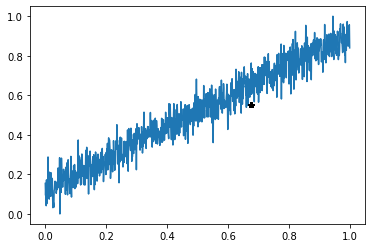

In [55]:
# get sample outputs

output = model(torch.from_numpy(linear_test).float())


output = output.detach().numpy()
plt.plot(linear_test[:,0], linear_test[:,1])
plt.plot(output[:,0], output[:,1], 'k*')
plt.show()

In [66]:
# Model 3

# Simple auto encoder
lr_rate = 0.0001

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr= lr_rate)

# mean-squared error loss
criterion = nn.MSELoss()

outputs = []
data = torch.from_numpy(linear_train)
data = data.float()
num_epochs = 500
for epoch in range(num_epochs):
    recon = model(data)
    loss = criterion(recon, data)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    outputs.append((epoch, recon),)


Epoch:1, Loss:0.0754
Epoch:2, Loss:0.0685
Epoch:3, Loss:0.0632
Epoch:4, Loss:0.0593
Epoch:5, Loss:0.0560
Epoch:6, Loss:0.0527
Epoch:7, Loss:0.0505
Epoch:8, Loss:0.0490
Epoch:9, Loss:0.0477
Epoch:10, Loss:0.0464
Epoch:11, Loss:0.0452
Epoch:12, Loss:0.0441
Epoch:13, Loss:0.0430
Epoch:14, Loss:0.0419
Epoch:15, Loss:0.0408
Epoch:16, Loss:0.0397
Epoch:17, Loss:0.0387
Epoch:18, Loss:0.0376
Epoch:19, Loss:0.0366
Epoch:20, Loss:0.0356
Epoch:21, Loss:0.0346
Epoch:22, Loss:0.0337
Epoch:23, Loss:0.0327
Epoch:24, Loss:0.0318
Epoch:25, Loss:0.0310
Epoch:26, Loss:0.0301
Epoch:27, Loss:0.0292
Epoch:28, Loss:0.0284
Epoch:29, Loss:0.0277
Epoch:30, Loss:0.0270
Epoch:31, Loss:0.0262
Epoch:32, Loss:0.0255
Epoch:33, Loss:0.0248
Epoch:34, Loss:0.0241
Epoch:35, Loss:0.0234
Epoch:36, Loss:0.0228
Epoch:37, Loss:0.0221
Epoch:38, Loss:0.0215
Epoch:39, Loss:0.0209
Epoch:40, Loss:0.0203
Epoch:41, Loss:0.0198
Epoch:42, Loss:0.0193
Epoch:43, Loss:0.0188
Epoch:44, Loss:0.0183
Epoch:45, Loss:0.0178
Epoch:46, Loss:0.01

Epoch:362, Loss:0.0029
Epoch:363, Loss:0.0029
Epoch:364, Loss:0.0029
Epoch:365, Loss:0.0029
Epoch:366, Loss:0.0029
Epoch:367, Loss:0.0029
Epoch:368, Loss:0.0029
Epoch:369, Loss:0.0029
Epoch:370, Loss:0.0029
Epoch:371, Loss:0.0029
Epoch:372, Loss:0.0029
Epoch:373, Loss:0.0029
Epoch:374, Loss:0.0029
Epoch:375, Loss:0.0029
Epoch:376, Loss:0.0029
Epoch:377, Loss:0.0029
Epoch:378, Loss:0.0029
Epoch:379, Loss:0.0029
Epoch:380, Loss:0.0029
Epoch:381, Loss:0.0029
Epoch:382, Loss:0.0029
Epoch:383, Loss:0.0029
Epoch:384, Loss:0.0029
Epoch:385, Loss:0.0029
Epoch:386, Loss:0.0029
Epoch:387, Loss:0.0029
Epoch:388, Loss:0.0029
Epoch:389, Loss:0.0029
Epoch:390, Loss:0.0029
Epoch:391, Loss:0.0029
Epoch:392, Loss:0.0028
Epoch:393, Loss:0.0028
Epoch:394, Loss:0.0028
Epoch:395, Loss:0.0028
Epoch:396, Loss:0.0028
Epoch:397, Loss:0.0028
Epoch:398, Loss:0.0028
Epoch:399, Loss:0.0028
Epoch:400, Loss:0.0028
Epoch:401, Loss:0.0028
Epoch:402, Loss:0.0028
Epoch:403, Loss:0.0028
Epoch:404, Loss:0.0028
Epoch:405, 

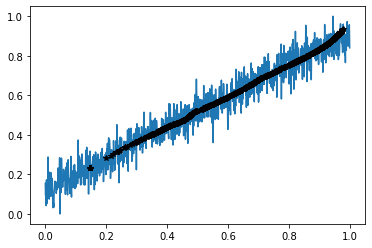

In [67]:
# get sample outputs

output = model(torch.from_numpy(linear_test).float())


output = output.detach().numpy()
plt.plot(linear_test[:,0], linear_test[:,1])
plt.plot(output[:,0], output[:,1], 'k*')
plt.show()

### Task 2:
Do the same but for the cubic data. Again, quantify the MSE on the test data but also plot the reconstructed data alongside the real data to see quality.

In [ ]:
# PCA completed above in Task 1

In [68]:
# Model 2

# Simple auto encoder
lr_rate = 0.0001

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = simpleAE().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr= lr_rate)

# mean-squared error loss
criterion = nn.MSELoss()

outputs = []
data = torch.from_numpy(cubic_train)
data = data.float()
num_epochs = 500
for epoch in range(num_epochs):
    recon = model(data)
    loss = criterion(recon, data)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    outputs.append((epoch, recon),)


Epoch:1, Loss:0.0792
Epoch:2, Loss:0.0792
Epoch:3, Loss:0.0792
Epoch:4, Loss:0.0792
Epoch:5, Loss:0.0792
Epoch:6, Loss:0.0792
Epoch:7, Loss:0.0792
Epoch:8, Loss:0.0792
Epoch:9, Loss:0.0792
Epoch:10, Loss:0.0792
Epoch:11, Loss:0.0792
Epoch:12, Loss:0.0791
Epoch:13, Loss:0.0791
Epoch:14, Loss:0.0791
Epoch:15, Loss:0.0791
Epoch:16, Loss:0.0791
Epoch:17, Loss:0.0791
Epoch:18, Loss:0.0791
Epoch:19, Loss:0.0791
Epoch:20, Loss:0.0791
Epoch:21, Loss:0.0791
Epoch:22, Loss:0.0791
Epoch:23, Loss:0.0791
Epoch:24, Loss:0.0791
Epoch:25, Loss:0.0791
Epoch:26, Loss:0.0790
Epoch:27, Loss:0.0790
Epoch:28, Loss:0.0790
Epoch:29, Loss:0.0790
Epoch:30, Loss:0.0790
Epoch:31, Loss:0.0790
Epoch:32, Loss:0.0790
Epoch:33, Loss:0.0790
Epoch:34, Loss:0.0790
Epoch:35, Loss:0.0790
Epoch:36, Loss:0.0790
Epoch:37, Loss:0.0790
Epoch:38, Loss:0.0790
Epoch:39, Loss:0.0790
Epoch:40, Loss:0.0789
Epoch:41, Loss:0.0789
Epoch:42, Loss:0.0789
Epoch:43, Loss:0.0789
Epoch:44, Loss:0.0789
Epoch:45, Loss:0.0789
Epoch:46, Loss:0.07

Epoch:387, Loss:0.0768
Epoch:388, Loss:0.0768
Epoch:389, Loss:0.0768
Epoch:390, Loss:0.0768
Epoch:391, Loss:0.0768
Epoch:392, Loss:0.0768
Epoch:393, Loss:0.0768
Epoch:394, Loss:0.0768
Epoch:395, Loss:0.0768
Epoch:396, Loss:0.0768
Epoch:397, Loss:0.0768
Epoch:398, Loss:0.0768
Epoch:399, Loss:0.0768
Epoch:400, Loss:0.0768
Epoch:401, Loss:0.0768
Epoch:402, Loss:0.0768
Epoch:403, Loss:0.0768
Epoch:404, Loss:0.0768
Epoch:405, Loss:0.0767
Epoch:406, Loss:0.0767
Epoch:407, Loss:0.0767
Epoch:408, Loss:0.0767
Epoch:409, Loss:0.0767
Epoch:410, Loss:0.0767
Epoch:411, Loss:0.0767
Epoch:412, Loss:0.0767
Epoch:413, Loss:0.0767
Epoch:414, Loss:0.0767
Epoch:415, Loss:0.0767
Epoch:416, Loss:0.0767
Epoch:417, Loss:0.0767
Epoch:418, Loss:0.0767
Epoch:419, Loss:0.0767
Epoch:420, Loss:0.0767
Epoch:421, Loss:0.0767
Epoch:422, Loss:0.0767
Epoch:423, Loss:0.0767
Epoch:424, Loss:0.0767
Epoch:425, Loss:0.0766
Epoch:426, Loss:0.0766
Epoch:427, Loss:0.0766
Epoch:428, Loss:0.0766
Epoch:429, Loss:0.0766
Epoch:430, 

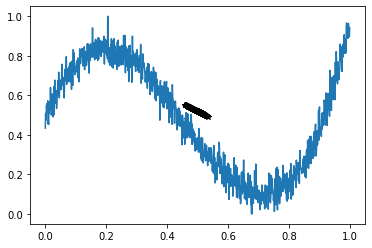

In [69]:
# get sample outputs

output = model(torch.from_numpy(cubic_test).float())


output = output.detach().numpy()
plt.plot(cubic_test[:,0], cubic_test[:,1])
plt.plot(output[:,0], output[:,1], 'k*')
plt.show()

In [71]:
# Model 3

# Simple auto encoder
lr_rate = 0.0001

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr= lr_rate)

# mean-squared error loss
criterion = nn.MSELoss()

outputs = []
data = torch.from_numpy(cubic_train)
data = data.float()
num_epochs = 500
for epoch in range(num_epochs):
    recon = model(data)
    loss = criterion(recon, data)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    outputs.append((epoch, recon),)

Epoch:1, Loss:0.0765
Epoch:2, Loss:0.0745
Epoch:3, Loss:0.0733
Epoch:4, Loss:0.0723
Epoch:5, Loss:0.0714
Epoch:6, Loss:0.0705
Epoch:7, Loss:0.0697
Epoch:8, Loss:0.0687
Epoch:9, Loss:0.0678
Epoch:10, Loss:0.0668
Epoch:11, Loss:0.0658
Epoch:12, Loss:0.0648
Epoch:13, Loss:0.0636
Epoch:14, Loss:0.0623
Epoch:15, Loss:0.0609
Epoch:16, Loss:0.0594
Epoch:17, Loss:0.0581
Epoch:18, Loss:0.0570
Epoch:19, Loss:0.0560
Epoch:20, Loss:0.0551
Epoch:21, Loss:0.0543
Epoch:22, Loss:0.0535
Epoch:23, Loss:0.0527
Epoch:24, Loss:0.0520
Epoch:25, Loss:0.0512
Epoch:26, Loss:0.0505
Epoch:27, Loss:0.0498
Epoch:28, Loss:0.0491
Epoch:29, Loss:0.0485
Epoch:30, Loss:0.0479
Epoch:31, Loss:0.0472
Epoch:32, Loss:0.0465
Epoch:33, Loss:0.0459
Epoch:34, Loss:0.0452
Epoch:35, Loss:0.0446
Epoch:36, Loss:0.0440
Epoch:37, Loss:0.0435
Epoch:38, Loss:0.0430
Epoch:39, Loss:0.0426
Epoch:40, Loss:0.0421
Epoch:41, Loss:0.0417
Epoch:42, Loss:0.0413
Epoch:43, Loss:0.0409
Epoch:44, Loss:0.0406
Epoch:45, Loss:0.0403
Epoch:46, Loss:0.03

Epoch:363, Loss:0.0090
Epoch:364, Loss:0.0089
Epoch:365, Loss:0.0089
Epoch:366, Loss:0.0089
Epoch:367, Loss:0.0089
Epoch:368, Loss:0.0089
Epoch:369, Loss:0.0089
Epoch:370, Loss:0.0089
Epoch:371, Loss:0.0088
Epoch:372, Loss:0.0088
Epoch:373, Loss:0.0088
Epoch:374, Loss:0.0088
Epoch:375, Loss:0.0088
Epoch:376, Loss:0.0088
Epoch:377, Loss:0.0088
Epoch:378, Loss:0.0088
Epoch:379, Loss:0.0087
Epoch:380, Loss:0.0087
Epoch:381, Loss:0.0087
Epoch:382, Loss:0.0087
Epoch:383, Loss:0.0087
Epoch:384, Loss:0.0087
Epoch:385, Loss:0.0087
Epoch:386, Loss:0.0087
Epoch:387, Loss:0.0086
Epoch:388, Loss:0.0086
Epoch:389, Loss:0.0086
Epoch:390, Loss:0.0086
Epoch:391, Loss:0.0086
Epoch:392, Loss:0.0086
Epoch:393, Loss:0.0086
Epoch:394, Loss:0.0085
Epoch:395, Loss:0.0085
Epoch:396, Loss:0.0085
Epoch:397, Loss:0.0085
Epoch:398, Loss:0.0085
Epoch:399, Loss:0.0086
Epoch:400, Loss:0.0086
Epoch:401, Loss:0.0086
Epoch:402, Loss:0.0086
Epoch:403, Loss:0.0085
Epoch:404, Loss:0.0088
Epoch:405, Loss:0.0087
Epoch:406, 

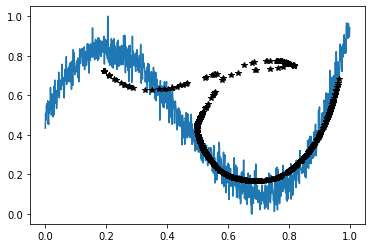

In [72]:
# get sample outputs

output = model(torch.from_numpy(cubic_test).float())


output = output.detach().numpy()
plt.plot(cubic_test[:,0], cubic_test[:,1])
plt.plot(output[:,0], output[:,1], 'k*')
plt.show()

### Task 3:
Train Model 3 on the cubic data, then feed the linear data through the trained AE to see how it does at reconstructing it. If you are unsure of what I mean, see the AE video lecture or ask. Hint, it should be terrible at this.


There are many things you can play around with here. You can change layer sizes, add more layers, adjust the learning rate, remove regularization, remove batch normalization. I encourage you to try some of these but it is not part of the assignment.

In [74]:
# Model 3

# Simple auto encoder
lr_rate = 0.0001

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr= lr_rate)

# mean-squared error loss
criterion = nn.MSELoss()

outputs = []
data = torch.from_numpy(cubic_train)
data = data.float()
num_epochs = 500
for epoch in range(num_epochs):
    recon = model(data)
    loss = criterion(recon, data)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    outputs.append((epoch, recon),)

Epoch:1, Loss:0.0679
Epoch:2, Loss:0.0658
Epoch:3, Loss:0.0637
Epoch:4, Loss:0.0616
Epoch:5, Loss:0.0595
Epoch:6, Loss:0.0574
Epoch:7, Loss:0.0555
Epoch:8, Loss:0.0538
Epoch:9, Loss:0.0522
Epoch:10, Loss:0.0508
Epoch:11, Loss:0.0495
Epoch:12, Loss:0.0483
Epoch:13, Loss:0.0471
Epoch:14, Loss:0.0459
Epoch:15, Loss:0.0447
Epoch:16, Loss:0.0435
Epoch:17, Loss:0.0424
Epoch:18, Loss:0.0413
Epoch:19, Loss:0.0404
Epoch:20, Loss:0.0396
Epoch:21, Loss:0.0388
Epoch:22, Loss:0.0379
Epoch:23, Loss:0.0371
Epoch:24, Loss:0.0363
Epoch:25, Loss:0.0356
Epoch:26, Loss:0.0349
Epoch:27, Loss:0.0343
Epoch:28, Loss:0.0337
Epoch:29, Loss:0.0331
Epoch:30, Loss:0.0325
Epoch:31, Loss:0.0319
Epoch:32, Loss:0.0314
Epoch:33, Loss:0.0308
Epoch:34, Loss:0.0303
Epoch:35, Loss:0.0299
Epoch:36, Loss:0.0294
Epoch:37, Loss:0.0289
Epoch:38, Loss:0.0284
Epoch:39, Loss:0.0279
Epoch:40, Loss:0.0274
Epoch:41, Loss:0.0270
Epoch:42, Loss:0.0266
Epoch:43, Loss:0.0262
Epoch:44, Loss:0.0257
Epoch:45, Loss:0.0253
Epoch:46, Loss:0.02

Epoch:371, Loss:0.0074
Epoch:372, Loss:0.0074
Epoch:373, Loss:0.0073
Epoch:374, Loss:0.0073
Epoch:375, Loss:0.0073
Epoch:376, Loss:0.0073
Epoch:377, Loss:0.0073
Epoch:378, Loss:0.0073
Epoch:379, Loss:0.0073
Epoch:380, Loss:0.0072
Epoch:381, Loss:0.0074
Epoch:382, Loss:0.0074
Epoch:383, Loss:0.0074
Epoch:384, Loss:0.0072
Epoch:385, Loss:0.0074
Epoch:386, Loss:0.0074
Epoch:387, Loss:0.0075
Epoch:388, Loss:0.0073
Epoch:389, Loss:0.0077
Epoch:390, Loss:0.0072
Epoch:391, Loss:0.0074
Epoch:392, Loss:0.0072
Epoch:393, Loss:0.0074
Epoch:394, Loss:0.0072
Epoch:395, Loss:0.0073
Epoch:396, Loss:0.0072
Epoch:397, Loss:0.0073
Epoch:398, Loss:0.0072
Epoch:399, Loss:0.0072
Epoch:400, Loss:0.0072
Epoch:401, Loss:0.0071
Epoch:402, Loss:0.0072
Epoch:403, Loss:0.0071
Epoch:404, Loss:0.0072
Epoch:405, Loss:0.0071
Epoch:406, Loss:0.0071
Epoch:407, Loss:0.0071
Epoch:408, Loss:0.0071
Epoch:409, Loss:0.0071
Epoch:410, Loss:0.0070
Epoch:411, Loss:0.0071
Epoch:412, Loss:0.0070
Epoch:413, Loss:0.0071
Epoch:414, 

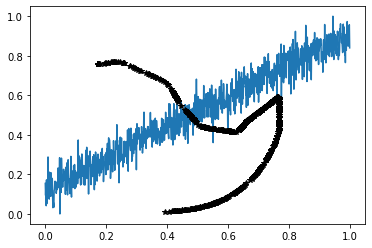

In [76]:
# get sample outputs

output = model(torch.from_numpy(linear_test).float())


output = output.detach().numpy()
plt.plot(linear_test[:,0], linear_test[:,1])
plt.plot(output[:,0], output[:,1], 'k*')
plt.show()

## Problem 2 - VAE

In this problem, you will work with a simple VAE applied to MNIST data. For this problem, I provide the code for 1) a VAE with a single layer encoder and decoder with a variable size latent space and 2) the VAE loss function.

#### Task 1
Train this VAE for a latent space of size 2 and 40 respectively. For each, plot the training and test loss as a function of training iteration to see how it performs for different sizes. 

#### Task 2
Train a VAE for sizes ranging from 2 --> 40 (in steps of 2 to reduce computation). Plot the training and test loss as a function of latent space size to assess how latent space size influences model results.

#### Task 3
For a VAEs with a latent space of size 5 and 20, assess the quality of reconstruction visually. To do this, you will need to 1) train this VAE, 2) plot a selection of (at least) of images, and 3) pass those images through the trained VAE to get the reconstructions back which you will plot. 

#### Task 4
Here you'll generate new data directly from the latent space. Use the previously trained VAE of size 20 for this. First, sample random latent values from the standardized normal latent space and generate sample images. Plot at least 5 such generated digit images. These may not look very good since, after all, you are generating latent values. So lets try again. This time, take an image of one of the digits (a 2 for example), pass it through the VAE to get a sample mean and log_variance. Now sample at least 5 values from that part of the latent space and generate images from them. You can use the existing forward and reparameterize methods to do this. Note I am being intentionally short on the description here. If you really understand the VAE, you will likely understand what I am asking for here. If you are unclear, please ask me to clarify and I will. 

Other things you can play with but I will not ask for. What happens when you change the width or depth of the encoder and ecoder models (symmetrically)? What happens if you do / don't use L2 regularization?

In [3]:
from torchvision import datasets, transforms
# training
BATCH_SIZE = 100
trainset = datasets.MNIST('./data/', train=True, download=True,
                   transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
# test
testset = datasets.MNIST('./data/', train=False, download=False,
                   transform=transforms.ToTensor())

testloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

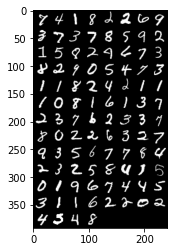

In [4]:
def show_images(images):
    images = torchvision.utils.make_grid(images)
    show_image(images[0])

def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
show_images(images)

In [7]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400) # Encoding layer
        
        # Latent mean and log variances
        self.fc2m = nn.Linear(400, latent_dim) # use for mean
        self.fc2s = nn.Linear(400, latent_dim) # use for standard deviation
        
        self.fc3 = nn.Linear(latent_dim, 400) # Decoding layer
        
        self.fc4 = nn.Linear(400, 784) # Convert output to [0,1] since that is what MNIST is
        
        
    # This method takes the mean and log_variance and produces a sample from it.    
    def reparameterize(self, log_var, mu):
        s = torch.exp(0.5*log_var)
        eps = torch.rand_like(s) # generate a iid standard normal same shape as s
        return eps.mul(s).add_(mu)
        
    def forward(self, input):
        x = input.view(-1, 784) # Format input
        
        x = torch.relu(self.fc1(x)) # Apply first linear layer followed by ReLU
        
        log_s = self.fc2s(x) # Get z log-variance
        m = self.fc2m(x) # Get z mean
        
        z = self.reparameterize(log_s, m) # Draw a latent value from the z~N(mu,sig)
        
        x = self.decode(z) # Apply the decoder to z.
        
        return x, m, log_s
    
    # This decode module can take a "z" directly and output a data instance from it.
    def decode(self, z):
        x = torch.relu(self.fc3(z))
        x = torch.sigmoid(self.fc4(x))
        return x

In [8]:
import torch.nn.functional as F

def loss(input_image, recon_image, mu, log_var):
    # First part calculates reconstruction error
    CE = F.binary_cross_entropy(recon_image, input_image.view(-1, 784), reduction='sum')
    
    # Second part computes the KL divergence
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return KLD + CE

## Task 1

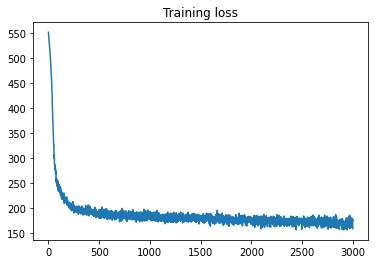

In [89]:
# Task 1: Train the VAE for latent space of size 2 and 40

## train
vae = VAE(2)

learning_rate = 1e-4
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate, weight_decay=1e-5)

train_loss = []
test_loss = []
for epoch in range(5):
    for i, data in enumerate(trainloader,0):
        images, labels = data
        optimizer.zero_grad()
        recon_image,s,mu = vae(images)
        lss = loss(images, recon_image, mu, s)
        lss.backward()
        train_loss.append(lss.item() / len(images))
        optimizer.step()

        
plt.plot(train_loss)
plt.title("Training loss")
plt.show()

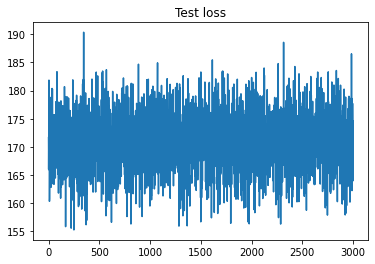

In [90]:
for epoch in range(5):
    for i, data in enumerate(testloader,0):
        images, labels = data
        recon_image,s,mu = vae.forward(images)
        lss= loss(images, recon_image, mu, s)
        lss.backward()
        test_loss.append(lss.item() / len(images))
        

plt.plot(test_loss)
plt.title("Test loss")
plt.show()

## Task 2

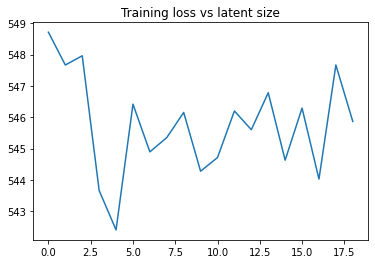

In [94]:
# Task 2: Train a VAE for sizes ranging from 2 --> 40 (in steps of 2 to reduce computation). 
# Plot the training and test loss as a function of latent space size to assess how latent space size influences model results.
train_loss = []
test_loss = []
learning_rate = 1e-4
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate, weight_decay=1e-5)

for latent_size in np.arange(2,40,2):
    
    vae = VAE(latent_size)

    
    for epoch in range(5):
        for i, data in enumerate(trainloader,0):
            images, labels = data
            optimizer.zero_grad()
            recon_image,s,mu = vae(images)
            lss = loss(images, recon_image, mu, s)
            lss.backward()
            optimizer.step()

    train_loss.append(lss.item() / len(images))
    
        
plt.plot(train_loss)
plt.title("Training loss vs latent size")
plt.show()

X AXIS IS OFF BECAUSE OF PLOTTING BUT GOES FROM 2-40 (did not want to rerun the code, it takes too long)

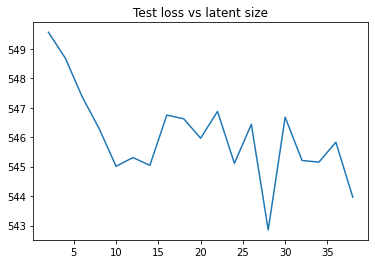

In [96]:
train_loss = []
test_loss = []
learning_rate = 1e-4
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate, weight_decay=1e-5)
latent_size_array = np.arange(2,40,2)

for latent_size in np.arange(2,40,2):
    
    vae = VAE(latent_size)

    
    for epoch in range(5):
        for i, data in enumerate(testloader,0):
            images, labels = data
            recon_image,s,mu = vae.forward(images)
            lss= loss(images, recon_image, mu, s)
            lss.backward()
    test_loss.append(lss.item() / len(images))
        

plt.plot(latent_size_array, test_loss)
plt.title("Test loss vs latent size")
plt.show()

## Task 3

Original Images:


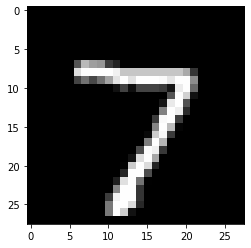

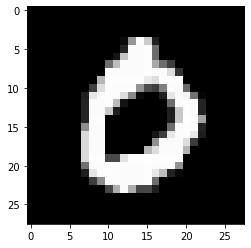

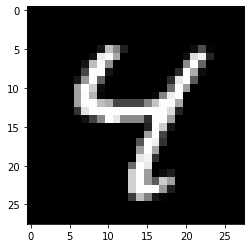

In [11]:
# Plot selection of images

print("Original Images:")
images0, labels0 = testset[0]
show_images(images0)

images3, labels3 = testset[3]
show_images(images3)

images6, labels6 = testset[6]
show_images(images6)

In [97]:
# For a VAEs with a latent space of size 5 and 20, assess the quality of reconstruction visually. 
# To do this, you will need to 1) train this VAE, 2) plot a selection of (at least) of images, and 
# 3) pass those images through the trained VAE to get the reconstructions back which you will plot.

# Latent size 5

## train
vae = VAE(5)

learning_rate = 1e-4
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate, weight_decay=1e-5)

train_loss = []
test_loss = []
for epoch in range(5):
    for i, data in enumerate(trainloader,0):
        images, labels = data
        optimizer.zero_grad()
        recon_image,s,mu = vae(images)
        lss = loss(images, recon_image, mu, s)
        lss.backward()
        train_loss.append(lss.item() / len(images))
        optimizer.step()

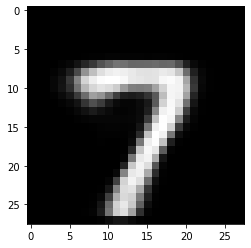

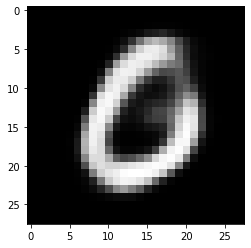

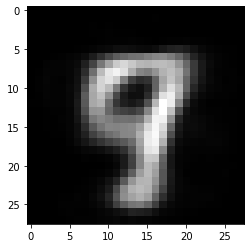

In [123]:
# Pass images through trained VAE

recon_image,s,mu = vae.forward(images0)
recon_image = recon_image.detach().numpy()
recon_image = recon_image.reshape((28, 28))
plt.imshow(recon_image, cmap = 'gray')
plt.show()

recon_image,s,mu = vae.forward(images3)
recon_image = recon_image.detach().numpy()
recon_image = recon_image.reshape((28, 28))
plt.imshow(recon_image, cmap = 'gray')
plt.show()

recon_image,s,mu = vae.forward(images6)
recon_image = recon_image.detach().numpy()
recon_image = recon_image.reshape((28, 28))
plt.imshow(recon_image, cmap = 'gray')
plt.show()

In [9]:
# Latent size 20

## train
vae = VAE(20)

learning_rate = 1e-4
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate, weight_decay=1e-5)

train_loss = []
test_loss = []
for epoch in range(5):
    for i, data in enumerate(trainloader,0):
        images, labels = data
        optimizer.zero_grad()
        recon_image,s,mu = vae(images)
        lss = loss(images, recon_image, mu, s)
        lss.backward()
        train_loss.append(lss.item() / len(images))
        optimizer.step()

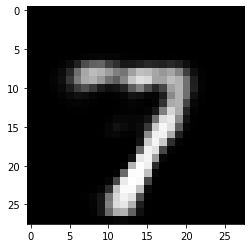

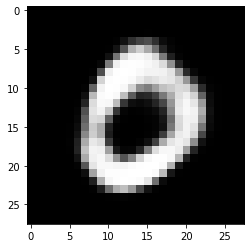

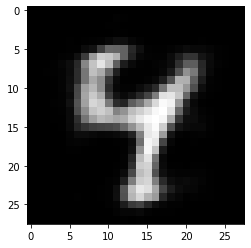

In [12]:

# Pass images through trained VAE

recon_image,s,mu = vae.forward(images0)
recon_image = recon_image.detach().numpy()
recon_image = recon_image.reshape((28, 28))
plt.imshow(recon_image, cmap = 'gray')
plt.show()

recon_image,s,mu = vae.forward(images3)
recon_image = recon_image.detach().numpy()
recon_image = recon_image.reshape((28, 28))
plt.imshow(recon_image, cmap = 'gray')
plt.show()

recon_image,s,mu = vae.forward(images6)
recon_image = recon_image.detach().numpy()
recon_image = recon_image.reshape((28, 28))
plt.imshow(recon_image, cmap = 'gray')
plt.show()

## Task 4

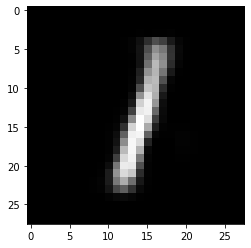

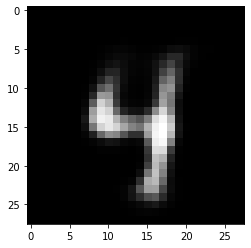

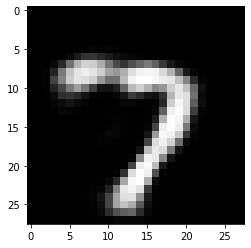

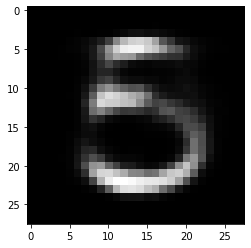

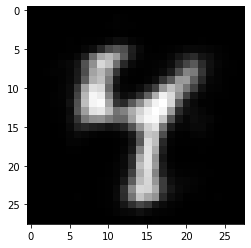

In [36]:
# Here you'll generate new data directly from the latent space. Use the previously trained VAE of size 20 for this. 
# First, sample random latent values from the standardized normal latent space and generate sample images. 
# Plot at least 5 such generated digit images. These may not look very good since, after all, you are generating latent values. 

latent1 = np.random.randint(1,40)
images, label = testset[latent1]
recon_image,s,mu = vae.forward(images)
recon_image = recon_image.detach().numpy()
recon_image = recon_image.reshape((28, 28))
plt.imshow(recon_image, cmap = 'gray')
plt.show()

latent1 = np.random.randint(1,40)
images, label = testset[latent1]
recon_image,s,mu = vae.forward(images)
recon_image = recon_image.detach().numpy()
recon_image = recon_image.reshape((28, 28))
plt.imshow(recon_image, cmap = 'gray')
plt.show()

latent1 = np.random.randint(1,40)
images, label = testset[latent1]
recon_image,s,mu = vae.forward(images)
recon_image = recon_image.detach().numpy()
recon_image = recon_image.reshape((28, 28))
plt.imshow(recon_image, cmap = 'gray')
plt.show()

latent1 = np.random.randint(1,40)
images, label = testset[latent1]
recon_image,s,mu = vae.forward(images)
recon_image = recon_image.detach().numpy()
recon_image = recon_image.reshape((28, 28))
plt.imshow(recon_image, cmap = 'gray')
plt.show()

latent1 = np.random.randint(1,40)
images, label = testset[latent1]
recon_image,s,mu = vae.forward(images)
recon_image = recon_image.detach().numpy()
recon_image = recon_image.reshape((28, 28))
plt.imshow(recon_image, cmap = 'gray')
plt.show()

Test image


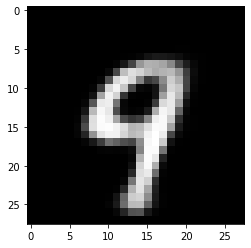

Generated images


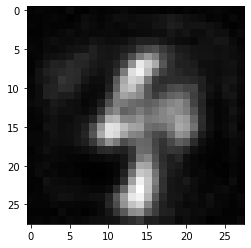

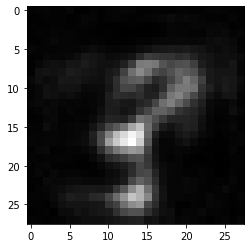

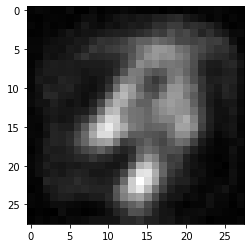

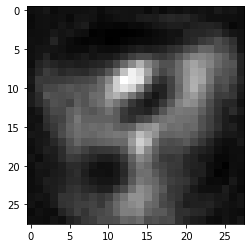

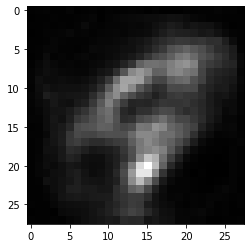

In [34]:
# So lets try again. This time, take an image of one of the digits (a 2 for example), pass it through the VAE to get a sample mean and log_variance. 
# Now sample at least 5 values from that part of the latent space and generate images from them. You can use the existing forward and reparameterize methods to do this. 
# Note I am being intentionally short on the description here. If you really understand the VAE, you will likely understand what I am asking for here. 
#If you are unclear, please ask me to clarify and I will.

print("Test image")
testimage, label = testset[12]
recon_image,s,mu = vae.forward(testimage) # get sample mean and log variance
recon_image = recon_image.detach().numpy()
recon_image = recon_image.reshape((28, 28))
plt.imshow(recon_image, cmap = 'gray')
plt.show()

print("Generated images")
z = vae.reparameterize(s, mu) # Draw a latent value from the z~N(mu,sig)        
x = vae.decode(z) # Apply the decoder to z.
x = x.detach().numpy()
x = x.reshape((28, 28))
plt.imshow(x, cmap = 'gray')
plt.show()

z = vae.reparameterize(s, mu) # Draw a latent value from the z~N(mu,sig)        
x = vae.decode(z) # Apply the decoder to z.
x = x.detach().numpy()
x = x.reshape((28, 28))
plt.imshow(x, cmap = 'gray')
plt.show()

z = vae.reparameterize(s, mu) # Draw a latent value from the z~N(mu,sig)        
x = vae.decode(z) # Apply the decoder to z.
x = x.detach().numpy()
x = x.reshape((28, 28))
plt.imshow(x, cmap = 'gray')
plt.show()

z = vae.reparameterize(s, mu) # Draw a latent value from the z~N(mu,sig)        
x = vae.decode(z) # Apply the decoder to z.
x = x.detach().numpy()
x = x.reshape((28, 28))
plt.imshow(x, cmap = 'gray')
plt.show()

z = vae.reparameterize(s, mu) # Draw a latent value from the z~N(mu,sig)        
x = vae.decode(z) # Apply the decoder to z.
x = x.detach().numpy()
x = x.reshape((28, 28))
plt.imshow(x, cmap = 'gray')
plt.show()